# Lab Part B

## Settings

Historically, the first panel method ever developed was a source-sheet method. At the time, Douglas Aircraft Company was concerned with calculating the flow around bodies of revolution, and it was only later that the method was extended to lifting surfaces. (See the reference below for a nice historical account.)

A source-panel method leads to a solution with no circulation, therefore no lift. The objective of this notebook is to start with the source panel method we implemented in the previous lesson and add some circulation so that we may have a lift force. We introduce an important concept: the Kutta-condition that allows us to determine what the right amount of circulation should be.

In [1]:
# import libraries and modules needed
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as plt

# integrate plots into the notebook
%matplotlib inline

## Load NACA0012 geometry

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


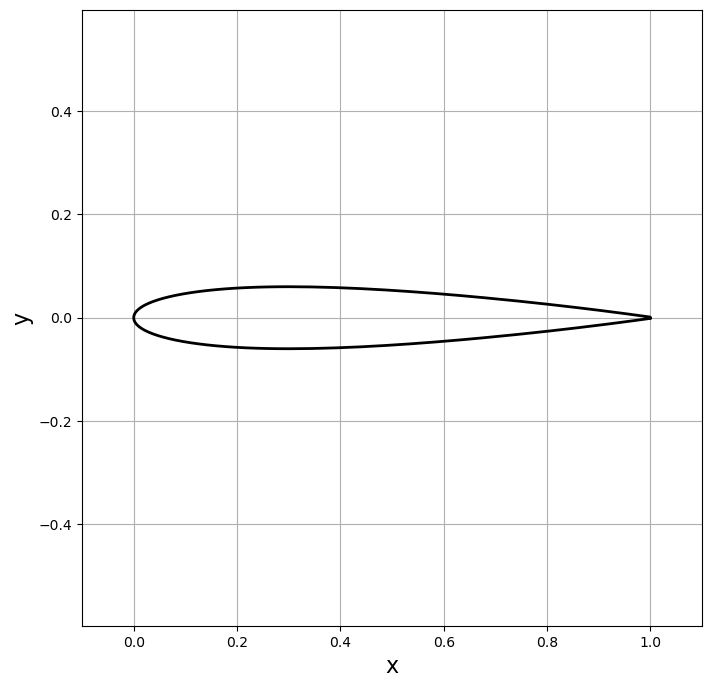

In [2]:
# read of the geometry from a data file
naca_filepath = 'naca0012.dat'
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 8
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);
plt.show()

## Discretization into Panels

We define a class Panel that will store all information about one panel: start and end points, center point, length, orientation, source strength, tangential velocity and pressure coefficient. We don't save the vortex-sheet strength because all panels will have the same value.

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        # Panel tangent angle (from xa,ya to xb,yb)
        self.theta = np.arctan2(yb - ya, xb - xa)
        # Outward normal angle
        self.beta = self.theta - np.pi/2
        # Panel center (collocation point)
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        # Label panel as upper/lower by geometry, not by angle
        self.loc = 'upper' if self.yc > 0 else 'lower'
        # To be filled later:
        self.gamma = 0.0
        self.vt = 0.0
        self.cp = 0.0

## Non-Uniform Panel Distribution

Like before, we call the function `define_panels` to discretize the airfoil geometry in `N` panels. The function will return a NumPy array of `N` objects of the type `Panel`.

In [4]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle
    
    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Now we can use our new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

In [5]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=40)

In [6]:
# plot discretized geometry
width = 8
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);
plt.axis('equal')

(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.06601892),
 np.float64(0.06601892))

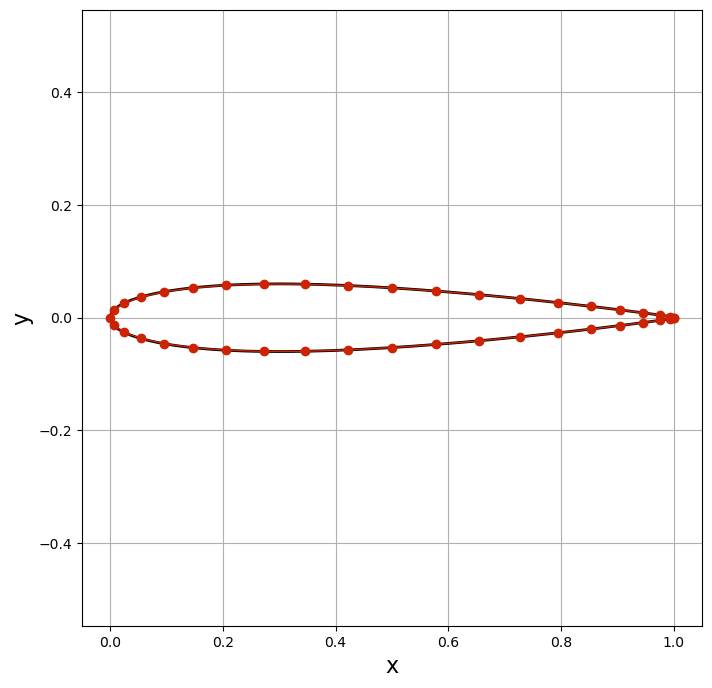

In [7]:
plt.show()

## Freestream Conditions


The airfoil is immersed in a free-stream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. Like before, we create a class for the free stream, even though we will only have one object that uses this class. It makes it easier to pass the free stream to other functions later on.

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees to radians

In [9]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

## Flow tangency boundary condition

To model potential flow around a body using the **vortex panel method**,  
we enforce the **flow-tangency (no-penetration) boundary condition** at the collocation point (center) of each panel.  
This condition ensures that the body’s surface is a dividing streamline — meaning no fluid crosses it.  
The accuracy of the solution increases as the number of panels $N_p$ is increased.

---

### Boundary condition for panel $i$
For each panel $i$, the normal velocity at its collocation point $(x_{c,i}, y_{c,i})$ must be zero:

$$
u_{n,i} = \frac{\partial \phi}{\partial n_i} (x_{c,i}, y_{c,i}) = 0
$$

---

### Expanded form in the vortex panel method
In the vortex panel formulation, this condition becomes:

$$
0 = U_\infty \cos(\beta_i - \alpha)
  + \sum_{\substack{j=1 \\ j \neq i}}^{N_p} \frac{\gamma_j}{2\pi}
    \int_{0}^{L_j}
      \frac{\partial \theta_{ij}}{\partial n_i} \, ds_j
$$

---

### Variable definitions
- $(x_{c,i}, y_{c,i})$ — collocation point (center) of panel $i$  
- $\beta_i$ — angle of the outward normal to panel $i$ (measured from $x$-axis)  
- $\alpha$ — freestream angle of attack  
- $U_\infty$ — freestream velocity magnitude  
- $\gamma_j$ — vortex strength of panel $j$  
- $x_j(s), y_j(s)$ — coordinates along panel $j$, parameterized by arc length $s$  
- $L_j$ — length of panel $j$

---

### Kernel for the normal projection
The induced velocity contribution in the normal direction is given by:

$$
\frac{\partial \theta_{ij}}{\partial n_i}
= \frac{
  -\,(y_{c,i} - y_j(s)) \cos\beta_i
  +\,(x_{c,i} - x_j(s)) \sin\beta_i
}{
  (x_{c,i} - x_j(s))^2 + (y_{c,i} - y_j(s))^2
}
$$

where:

$$
\theta_{ij} = \arctan\left( \frac{y_{c,i} - y_j(s)}{x_{c,i} - x_j(s)} \right)
$$


## Tangential Derivative (for Pressure Coefficient)

### Tangential Velocity on the Surface

After computing the vortex strengths $\{\gamma_j\}$,  
the **tangential velocity** along the surface at the collocation point $(x_{c,i}, y_{c,i})$ of panel $i$ is given by:

$$
u_{t,i} = \frac{\partial \phi}{\partial t_i}(x_{c,i}, y_{c,i})
= U_\infty \sin(\beta_i - \alpha)
+ \sum_{\substack{j=1 \\ j \neq i}}^{N_p} \frac{\gamma_j}{2\pi}
  \int_{0}^{L_j}
    \frac{\partial \theta_{ij}}{\partial t_i} \, ds_j
$$

---

### Kernel for Tangential Projection
The induced velocity component in the tangential direction is computed from:

$$
\frac{\partial \theta_{ij}}{\partial t_i}
= \frac{
  (y_{c,i} - y_j(s)) \sin\beta_i
  + (x_{c,i} - x_j(s)) \cos\beta_i
}{
  (x_{c,i} - x_j(s))^2 + (y_{c,i} - y_j(s))^2
}
$$

---

### Variable Definitions
- $(x_{c,i}, y_{c,i})$ — collocation point (center) of panel $i$  
- $\beta_i$ — tangent angle of panel $i$ relative to the $x$-axis  
- $\alpha$ — freestream angle of attack  
- $U_\infty$ — freestream speed  
- $\gamma_j$ — vortex strength of panel $j$  
- $x_j(s), y_j(s)$ — coordinates along panel $j$ as a function of arc length $s$  
- $L_j$ — length of panel $j$  
- $N_p$ — total number of panels  


## Cartesian Derivatives (for Full Velocity Field)




To compute the full velocity field $\mathbf{u} = (u, v)$ at arbitrary points in the flow domain,  
we use the definitions:

$$
u = \frac{\partial \phi}{\partial x}, \quad
v = \frac{\partial \phi}{\partial y}
$$

---

### Kernel Expressions for Cartesian Derivatives

For a panel $j$ influencing a point $(x_c, y_c)$, the derivatives of $\theta_{ij}$ are:

$$
\frac{\partial \theta_{ij}}{\partial x}
= \frac{ -\,(y_c - y_j) }
       { (x_c - x_j)^2 + (y_c - y_j)^2 }
$$

$$
\frac{\partial \theta_{ij}}{\partial y}
= \frac{ (x_c - x_j) }
       { (x_c - x_j)^2 + (y_c - y_j)^2 }
$$

---

### Variable Definitions
- $(x_c, y_c)$ — coordinates of the evaluation (field) point  
- $(x_j, y_j)$ — coordinates of a point along panel $j$  
- $\phi$ — velocity potential function  
- $u$ — $x$-component of the velocity  
- $v$ — $y$-component of the velocity  


These formulas match the kernel used in your integral function for the panel matrix and tangential velocity computations.



In [10]:
def integral(x, y, panel, cos_beta_i, sin_beta_i):
    """
    Evaluates the contribution of a vortex‐panel at one target point.

    Uses the kernel ∂θij/∂ni:
        ∂θij/∂ni = [–(y_i − y_j)·cosβ_i + (x_i − x_j)·sinβ_i] 
                   / [ (x_i − x_j)^2 + (y_i − y_j)^2 ]

    Parameters
    ----------
    x : float
        x-coordinate of the collocation (target) point, x_i.
    y : float
        y-coordinate of the collocation (target) point, y_i.
    panel : Panel
        The source panel j (with end-point panel.xa, panel.ya, 
        orientation panel.beta, and length panel.length).
    cos_beta_i : float
        Cosine of the normal direction on panel i (i.e. cos β_i).
    sin_beta_i : float
        Sine of the normal direction on panel i (i.e. sin β_i).

    Returns
    -------
    float
        The line integral ∫ (∂θij/∂ni) ds_j over panel j.
    """
    def integrand(s):
        xj = panel.xa + np.cos(panel.theta) * s
        yj = panel.ya + np.sin(panel.theta) * s
        dx = x - xj
        dy = y - yj
        return (-dy * cos_beta_i + dx * sin_beta_i) / (dx*dx + dy*dy)
    value, _ = integrate.quad(integrand, 0.0, panel.length)
    return value

## Building the Linear System


We now assemble and solve the linear system of equations:

$$
[A] \, [\gamma] = [b]
$$

Here, $[\gamma]$ is the vector of unknown vortex strengths for each panel.  
Each entry of the matrix $[A]$ is calculated using the `integral()` function with the appropriate projection:  
$\cos\beta_i$ and $\sin\beta_i$, which are the components of the outward normal to panel $i$.

The right-hand side vector $[b]$ contains the normal component of the freestream velocity at each control point.

Finally, we solve the system using `np.linalg.solve()` — or `np.linalg.lstsq()` if a least-squares approach is needed when the matrix is not square —  
to determine the vortex strengths for all panels.


## Kutta Condition

To ensure finite velocity and a smooth flow pattern at the trailing edge — known as the *Kutta condition* —  
we require that the vortex strengths on the two panels meeting at the trailing edge satisfy:

$$
\gamma_N + \gamma_1 = 0 \quad \Longrightarrow \quad \gamma_N = -\gamma_1
$$

where $N$ is the total number of panels.

In implementation, this is enforced by replacing the last row of the linear system (which would normally represent the boundary condition for one panel)  
with the Kutta condition equation above. This keeps the system square and solvable.

Applying the Kutta condition ensures that the circulation is selected so that the flow departs smoothly from the trailing edge,  
in agreement with classical thin airfoil theory.


In [11]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = np.zeros((N, N))
    for i, p_i in enumerate(panels):
        cos_b = np.cos(p_i.beta)
        sin_b = np.sin(p_i.beta)
        for j, p_j in enumerate(panels):
            if i == j:
                A[i, j] = 0.0  # For vortex panels, self-induced normal velocity = 0
            else:
                A[i, j] = (1/(2*np.pi)) * integral(
                    p_i.xc, p_i.yc, p_j, cos_b, sin_b
                )
    # Kutta condition: γ1 + γN = 0 (enforce at last row)
    A[-1, :] = 0.0
    A[-1, 0] = 1.0
    A[-1, -1] = 1.0
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """    
    N = len(panels)
    b = np.zeros(N)
    for i, p in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - p.beta)
    b[-1] = 0.0  # Kutta condition row
    return b

In [12]:
A = build_matrix(panels)           # compute the singularity matrix
b = build_rhs(panels, freestream)  # compute the freestream RHS
# solve the linear system
gamma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.gamma = gamma[i]

## Pressure Coefficient on Each Panel

After determining the vortex strengths, we apply **Bernoulli’s equation** to compute the pressure coefficient on each panel:

$$
C_{p_i} = 1 - \left( \frac{u_{t_i}}{U_\infty} \right)^2
$$

Here, $u_{t_i}$ is the **tangential velocity** at the midpoint of the $i$-th panel, calculated as:

$$
u_{t_i} =
U_\infty \sin(\beta_i - \alpha)
+ \sum_{\substack{j=1 \\ j \neq i}}^{N_p}
    \frac{\gamma_j}{2\pi}
    \int_{0}^{L_j}
      \frac{\partial \theta_{ij}}{\partial t_i} \,\mathrm{d}s_j
$$

Where:  
- $U_\infty$ is the freestream speed  
- $\beta_i$ is the tangent direction angle of panel $i$  
- $\alpha$ is the angle of attack  
- $\gamma_j$ is the vortex strength of panel $j$  

The **kernel** for the tangential projection is:

$$
\frac{\partial \theta_{ij}}{\partial t_i} =
\frac{
  \left( y_{c_i} - y_j(s) \right) \sin \beta_i
  + \left( x_{c_i} - x_j(s) \right) \cos \beta_i
}{
  \left( x_{c_i} - x_j(s) \right)^2 + \left( y_{c_i} - y_j(s) \right)^2
}
$$

This kernel matches the implementation in the `integral()` function used to evaluate the induced tangential velocity at each panel.


In [13]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels using the vortex panel method.

    Parameters
    ----------
    panels : list of Panel objects
        The vortex panels (must already have gamma assigned).
    freestream : Freestream object
        The freestream conditions (alpha in radians, u_inf).
    """
    for i, p_i in enumerate(panels):
        # Panel tangent direction: (cos(theta), sin(theta))
        tan_x = np.cos(p_i.theta)
        tan_y = np.sin(p_i.theta)
        vt = freestream.u_inf * np.cos(freestream.alpha - p_i.theta)  # Freestream tangent component

        for j, p_j in enumerate(panels):
            if i == j:
                continue
            vt += (1/(2*np.pi)) * p_j.gamma * integral(
                p_i.xc, p_i.yc, p_j,
                tan_x, tan_y
            )
        p_i.vt = vt

In [14]:
# compute the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [15]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The vortex panels, each with a computed `.vt` (tangential velocity).
    freestream: Freestream object
        The freestream conditions.
    """
    for p in panels:
        p.cp = 1.0 - (p.vt / freestream.u_inf)**2

In [16]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

## Theoretical solution


There is a classical method to obtain the theoretical characteristics of airfoils, known as *Theodorsen's method*.  
It uses the Joukowski transformation, but is able to deal with any airfoil by an additional transformation between a "near circle" and a circle.  
The method is quite complex! But the resulting values of the pressure coefficient are provided for some airfoils in table form  
in the 1945 [NACA Report No.824](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf), available from the NASA web server (see p. 71).

The values of:

$$
\left( \frac{u}{U_\infty} \right)^2
$$

are given for several stations along the chord length.  
We transcribed them here, saving them into an array:



In [17]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)
xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[0.    0.64  1.01  1.241 1.378 1.402 1.411 1.411 1.399 1.378 1.35  1.288
 1.228 1.166 1.109 1.044 0.956 0.906 0.   ]
[0.     0.005  0.0125 0.025  0.05   0.075  0.1    0.15   0.2    0.25
 0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.95   1.    ]


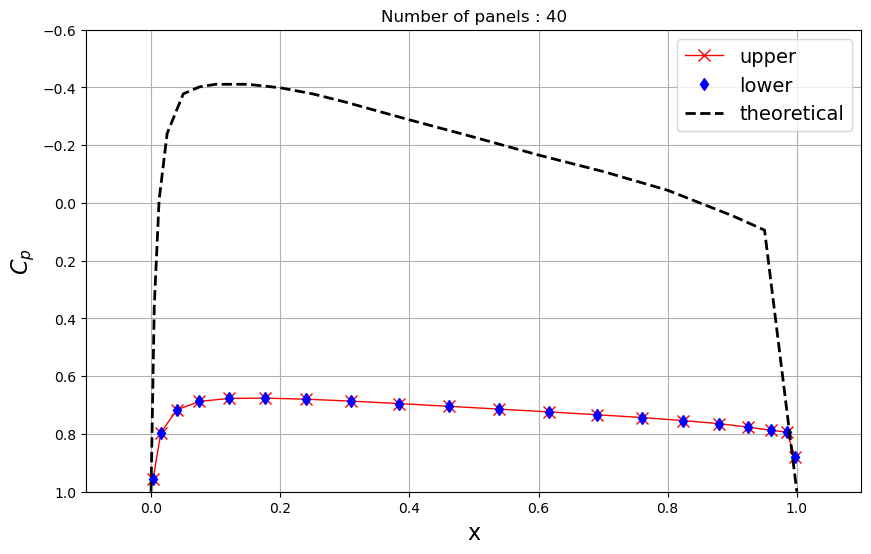

In [18]:
# plot the surface pressure coefficient
N=40 #number of panels
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
plt.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
plt.legend(loc='best', prop={'size':14})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -0.6)
plt.title('Number of panels : {}'.format(N));
plt.show()

As shown in the graph, the computed pressure coefficient values are significantly lower than the theoretical ones. This discrepancy may result from limitations of the panel method or from an insufficient number of panels. Increasing the number of panels, improving their distribution along the airfoil, or using a more accurate computational approach could reduce the error and yield results that align more closely with theory.


In [25]:

def Check_panel_solution(freestream, panels):
    """
    Quick consistency audit for a vortex panel solution:
      1) Normal (no-penetration) residuals at collocation points.
      2) Tangential velocity at the trailing edge (should be finite).
      3) Kutta residual: gamma at first + last panels.
      4) Total circulation and lift coefficient vs. thin-airfoil theory.

    Parameters
    ----------
    freestream : Freestream
        Attributes: u_inf (speed), alpha (radians), c (chord length, optional if geometry gives it).
    panels : list[Panel]
        Each Panel exposes: xa, ya, xb, yb, xc, yc, beta, length, gamma.

    Prints
    ------
    - max |u_n|    : largest normal-BC violation
    - u_t(TE)      : tangential velocity at TE
    - Kutta sum    : gamma_1 + gamma_N
    - Gamma        : total circulation
    - Cl vs theory : computed Cl and 2π·alpha
    """
    # 1) Normal boundary-condition residuals (at collocation points)
    bc_normal = []
    for pi in panels:
        # Freestream normal component (sign depends on convention)
        un = freestream.u_inf * np.cos(freestream.alpha - pi.beta)
        # Add induced normal velocity from all other panels
        for pj in panels:
            if pj is pi:
                continue
            un += (pj.gamma / (2 * np.pi)) * integral(
                pi.xc, pi.yc, pj,
                np.cos(pi.beta),  # n_x
                np.sin(pi.beta)   # n_y
            )
        bc_normal.append(un)
    bc_normal = np.asarray(bc_normal)

    # 2) Tangential velocity at trailing edge panel (assumed last)
    te = panels[-1]
    ut_te = freestream.u_inf * np.sin(freestream.alpha - te.beta)
    for pj in panels:
        ut_te += (pj.gamma / (2 * np.pi)) * integral(
            te.xb, te.yb, pj,
            np.sin(te.beta),   # t_x
            -np.cos(te.beta)   # t_y  (right-hand rotation of normal)
        )

    # 3) Kutta condition residual: gamma_first + gamma_last
    kutta_resid = panels[0].gamma + panels[-1].gamma

    # 4) Total circulation and lift coefficient
    Gamma = abs(sum(p.gamma * p.length for p in panels))

    # Chord length: infer from panel endpoints if not provided on freestream
    if hasattr(freestream, "c") and freestream.c is not None:
        chord = freestream.c
    else:
        x_max = max(max(p.xa, p.xb) for p in panels)
        x_min = min(min(p.xa, p.xb) for p in panels)
        chord = x_max - x_min

    # Cl ~ Gamma / (0.5 * U_inf * c)
    Cl = Gamma / (0.5 * freestream.u_inf * chord)
    Cl_thin = 2 * np.pi * freestream.alpha

    # Report
    print(f"Normal BC (no-penetration) residual: max|u_n| = {np.abs(bc_normal).max():.3e}")
    print(f"Tangential velocity at TE: u_t(TE) = {ut_te:.3e}")
    print(f"Kutta residual (gamma_1 + gamma_N) = {kutta_resid:.3e}")
    print(f"Total circulation Γ = {Gamma:.3e}")
    print(f"Lift coefficient: Cl = {Cl:.3f}  |  Thin-airfoil theory (2π·α) = {Cl_thin:.3f}")

# Example call (note the new argument order: freestream first)
Check_panel_solution(freestream, panels)


Normal BC (no-penetration) residual: max|u_n| = 2.315e-01
Tangential velocity at TE: u_t(TE) = 2.659e+00
Kutta residual (gamma_1 + gamma_N) = 0.000e+00
Total circulation Γ = 1.021e+00
Lift coefficient: Cl = 2.042  |  Thin-airfoil theory (2π·α) = 1.755


C:\Users\Rafi\AppData\Local\Temp\ipykernel_17524\4211345580.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  value, _ = integrate.quad(integrand, 0.0, panel.length)


## Plotting Streamlines Around the Airfoil

To visualize the flow field around the NACA 0012 airfoil at an angle of attack of 10 degrees, we follow these steps:

1. The freestream is set at an angle of 10° relative to the chord line of the airfoil.
2. The linear system for determining the vortex strengths on each panel is assembled and solved.
3. A rectangular grid of points is generated to cover the region around the airfoil.
4. At each point in the grid, the total velocity is calculated as the superposition of the freestream and the influence of all vortex panels.
5. The resulting flow field is visualized using streamlines, showing how the flow is deflected around the airfoil.

This visualization clearly illustrates how the airfoil at a 10° angle of attack modifies the surrounding flow.  
The streamlines curve around the airfoil, satisfying the no-penetration boundary condition enforced by the vortex panel method, and demonstrating the aerodynamic effects induced by the angle of attack.



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


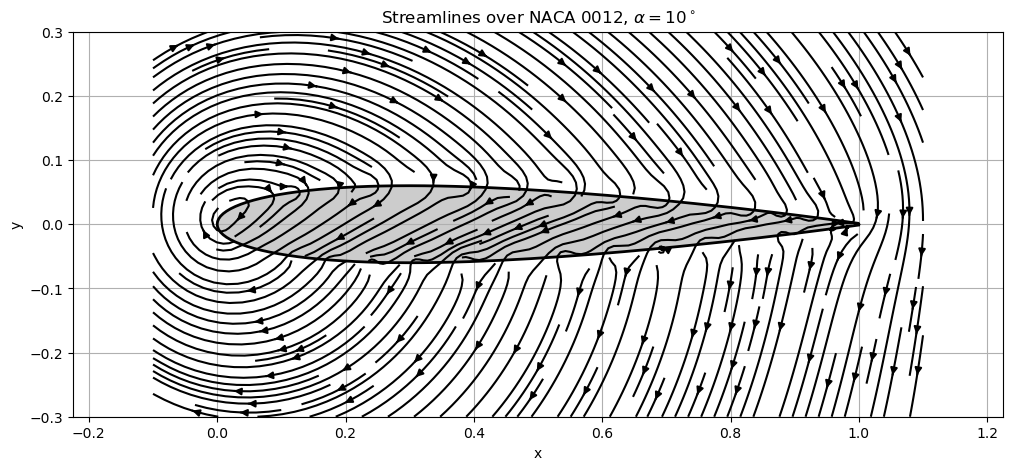

In [20]:
# Set freestream with angle of attack 10 degrees
alpha = 10
freestream = Freestream(u_inf=1.0, alpha=alpha)

# Solve the linear system for gamma (vortex strengths)
A = build_matrix(panels)
b = build_rhs(panels, freestream)
gamma = np.linalg.solve(A, b)
for i, panel in enumerate(panels):
    panel.gamma = gamma[i]

# Create mesh grid for flow visualization
X, Y = np.meshgrid(np.linspace(-0.1, 1.1, 200), np.linspace(-0.3, 0.3, 200))
u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X)
v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(Y)

# Superimpose vortex influence from each panel
for panel in panels:
    dx = X - panel.xc
    dy = Y - panel.yc
    r2 = dx**2 + dy**2
    u += -panel.gamma * dy / (2 * np.pi * r2)
    v +=  panel.gamma * dx / (2 * np.pi * r2)

# Plot airfoil and streamlines
plt.figure(figsize=(12, 5))
plt.grid()
plt.plot(x, y, color='k', linewidth=2)
plt.streamplot(X, Y, u, v, color='k', density=2, arrowsize=1)
plt.fill([panel.xa for panel in panels], [panel.ya for panel in panels], 'k', lw=2, alpha=0.2)
plt.title('Streamlines over NACA 0012, $\\alpha=10^\\circ$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.3, 0.3)
plt.show()

The graph shows the streamlines around a NACA 0012 airfoil at an angle of attack of $10^\circ$.  
Here too, the streamlines intersect the airfoil, indicating a non-physical result.


## Calculating $C_L$ as a Function of Angle of Attack

To analyze how the lift coefficient $C_L$ varies with angle of attack $\alpha$,  
we solve the vortex panel method over a range of angles from $-3^\circ$ to $16^\circ$.

For each value of $\alpha$:

- The freestream angle is updated in the simulation.
- The linear system for vortex strengths is reconstructed and solved.
- The total circulation around the airfoil is calculated and used to compute the lift coefficient $C_L$.
- The theoretical lift coefficient from thin airfoil theory, $C_L = 2\pi\alpha$, is also evaluated for comparison.

The resulting lists, `cls` and `cls_theory`, contain the panel method and theoretical lift coefficients, respectively,  
for each angle of attack in `alphas_deg`. This enables comparison between the numerical results and classical theory across the full range of angles.


In [21]:
alphas_deg = np.linspace(-3, 16, 24)  # in degrees
cls = []
cls_theory = []

for alpha_deg in alphas_deg:
    alpha_rad = np.radians(alpha_deg)
    # Update freestream object
    freestream.alpha = alpha_rad
    
    # Recompute RHS and solve for gamma
    b = build_rhs(panels, freestream)
    A = build_matrix(panels)
    gamma = np.linalg.solve(A, b)
    for i, panel in enumerate(panels):
        panel.gamma = gamma[i]
    
    # Compute total circulation
    circ = sum(panel.gamma * panel.length for panel in panels)
    c = max(max(p.xa, p.xb) for p in panels) - min(min(p.xa, p.xb) for p in panels)
    cl = -circ / (0.5 * freestream.u_inf * c)
    cls.append(cl)
    
    # Theory
    cls_theory.append(2 * np.pi * alpha_rad)

alphas = alphas_deg  # for x-axis

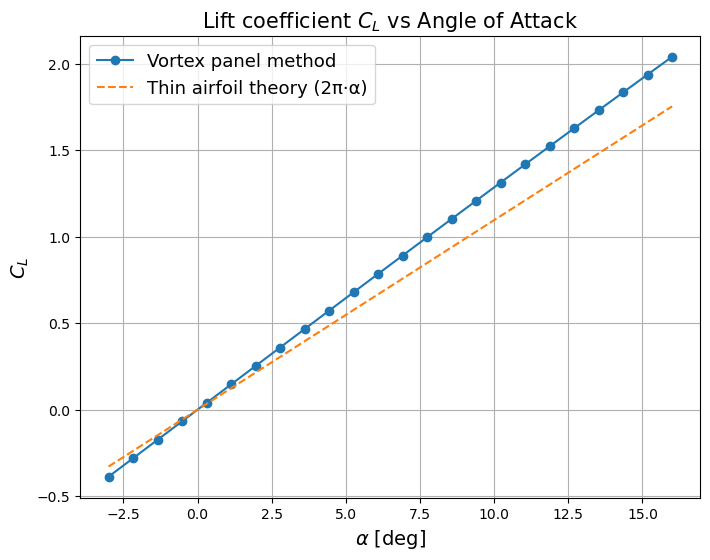

In [22]:
plt.figure(figsize=(8,6))
plt.plot(alphas, cls, 'o-', label='Vortex panel method')
plt.plot(alphas, cls_theory, '--', label='Thin airfoil theory (2π·α)')
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$C_L$', fontsize=14)
plt.grid(True)
plt.legend(fontsize=13)
plt.title('Lift coefficient $C_L$ vs Angle of Attack', fontsize=15)
plt.show()

This graph presents the lift coefficient as a function of the angle of attack.  
The orange trend line represents thin airfoil theory, while the blue line represents the panel method.  

It can be seen that for small angles of attack close to zero, the panel method produces a relatively small error,  
but this error increases as the angle moves further from zero.  

According to thin airfoil theory, for a symmetric airfoil the lift coefficient at zero angle of attack is indeed zero.  
Both curves pass through the origin.


## Sign of the Lift Coefficient ($C_L$)

In aerodynamics, the lift coefficient $C_L$ is expected to be positive for a positive angle of attack ($\alpha$) on a symmetric airfoil such as the NACA 0012.  
Physically, this means that when the airfoil is tilted upward into the freestream, it generates upward lift.

For the vortex panel method to produce physically meaningful results, it is essential that all angle definitions, panel orientations, and circulation directions are consistent with standard aerodynamic conventions.  
Once these elements are correctly implemented, the computed lift coefficient $C_L$ should increase with increasing $\alpha$,  
and should closely follow the theoretical prediction for a thin symmetric airfoil: $C_L = 2\pi\alpha$.


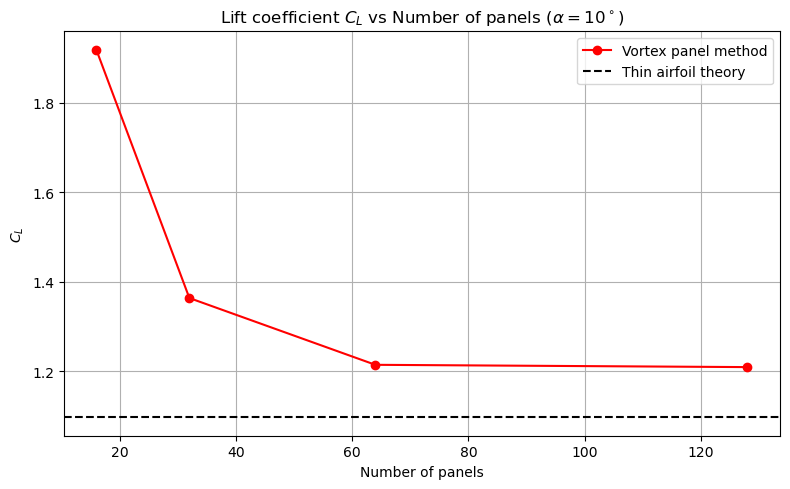

In [24]:
panel_counts = [16, 32, 64, 128]
alpha_deg = 10  # Angle of attack, can be changed
alpha_rad = np.radians(alpha_deg)

# Load geometry from file
x, y = np.loadtxt('naca0012.dat', dtype=float, delimiter='\t', unpack=True)

def compute_cl(N):
    panels = define_panels(x, y, N)
    freestream = Freestream(u_inf=1.0, alpha=alpha_deg)
    A = build_matrix(panels)
    b = build_rhs(panels, freestream)
    gamma = np.linalg.solve(A, b)
    for i, panel in enumerate(panels):
        panel.gamma = gamma[i]
    # Total circulation
    circulation = sum(panel.gamma * panel.length for panel in panels)
    chord = max(max(panel.xa, panel.xb) for panel in panels) - min(min(panel.xa, panel.xb) for panel in panels)
    Cl = -circulation / (0.5 * freestream.u_inf * chord)
    return Cl

# Calculate Cl for each panel count
cl_values = [compute_cl(N) for N in panel_counts]
theory_cl = 2 * np.pi * alpha_rad  # Thin airfoil theory for symmetric foil

# Plot results
plt.figure(figsize=(8,5))
plt.plot(panel_counts, cl_values, 'o-',color='red', label='Vortex panel method')
plt.axhline(theory_cl, color='k', linestyle='--', label='Thin airfoil theory')
plt.xlabel('Number of panels')
plt.ylabel('$C_L$')
plt.title(f'Lift coefficient $C_L$ vs Number of panels ($\\alpha={alpha_deg}^\\circ$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In this figure, the lift coefficient $C_L$ is shown as a function of the number of panels,  
for an angle of attack of $10^\circ$ (red line).  
According to thin airfoil theory, for this angle of attack we obtain  
$C_L = 1.0966$.  

It can be observed that starting from 64 panels,  
the panel method result provides a good approximation to the theory  
(black dashed line).


